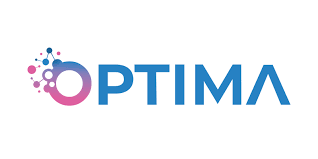
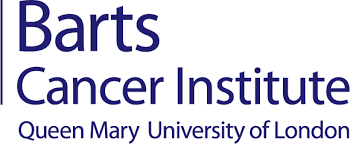

<div style="text-align: center; margin: 20px; background-color: #f9f9f9; padding: 20px; border-radius: 10px;">
    <h1 style="font-family: Arial, sans-serif; color: #333;">OPTIMA Prototyping Workshop, Berlin</h1>
    <a href="#" style="text-decoration: none; padding: 10px 20px; background-color: #4CAF50; color: white; border-radius: 5px; font-weight: bold; transition: background-color 0.3s;">
        November 6-8, 2024
    </a>
</div>


# Tissue Classification in WSI Framework Using AI
# -------------------------------------------------------------------------------------------------

**Author:** Dr. Oscar Maiques and Dr. Vivek Kumar Singh  
**Date:** November 06, 2024  
**Copyright:** 2024, Multiclass patch classification in histopathology whole slides Images  
**Maintainer:** Dr. Oscar Maiques and Dr. Vivek Kumar Singh   
**Credits:** Dr. Oscar Maiques and Dr. Vivek Kumar Singh  
**Email:** [o.m.carlos@qmul.ac.uk](mailto:o.m.carlos@qmul.ac.uk) and  [vivek.singh@qmul.ac.uk](mailto:vivek.singh@qmul.ac.uk)  
**Status:** Development  




## Overview
This project involves using a ResNet-50 model for patch classification in whole slide images (WSIs) from the TCGA breast cancer dataset. The goal is to classify each patch into one of 8 different classes: background, adipose, stroma, immune, tumor, normal, complex, and necrosis. The dataset for training consists of several TCGA breast images with supervised annotations. To facilitate training, the WSIs were divided into patches of 256x256 pixels, with each patch labeled according to its corresponding class. This approach allows for robust training and testing of the model, enabling accurate classification of various tissue types in breast cancer pathology.


## Pipeline Steps

1. **Import Libraries:** Essential libraries like PyTorch, NumPy, and Matplotlib are imported.

2. **Data Preparation:**
   - **Load Dataset:** Digital Pathology and labels are loaded.
   - **Data Augmentation:** Techniques like rotation and flipping enhance the dataset.
   - **Data Splitting:** The dataset is divided into training, validation, and test sets.

3. **Model Development:**
   - **Model Architecture:** A Convolutional Neural Network (CNN) is defined.
   - **Loss Function and Optimizer:** CrossEntropyLoss and Adam optimizer are selected.

4. **Model Training:** The model is trained on the training set, with metrics recorded for validation.

5. **Model Evaluation:**
   - **Testing:** The model's performance is assessed on the test set.
   - **Confusion Matrix & ROC Curve:** Visualizations are generated to evaluate classification performance.

6. **Results Visualization:** Plots of accuracy, loss, confusion matrix, and ROC curves are provided for analysis.

7. **Conclusion:** Summary of findings and insights into model effectiveness in classifying tissue types.


# Mount Drive and Unzip Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # # Extract zip files

! unzip '/content/drive/MyDrive/Optima/data.zip' -d '/content/drive/MyDrive/Optima/'

! unzip '/content/drive/MyDrive/Optima/Patches2.zip' -d '/content/drive/MyDrive/Optima/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Optima/data/split/test/Adipose/TCGA-W8-A86G-01Z-00-DX2_Adipose_54192_47220_256px.tif  
  inflating: /content/drive/MyDrive/Optima/data/split/test/Adipose/TCGA-W8-A86G-01Z-00-DX2_Adipose_54192_47476_256px.tif  
  inflating: /content/drive/MyDrive/Optima/data/split/test/Adipose/TCGA-W8-A86G-01Z-00-DX2_Adipose_54192_47732_256px.tif  
  inflating: /content/drive/MyDrive/Optima/data/split/test/Adipose/TCGA-W8-A86G-01Z-00-DX2_Adipose_54192_47988_256px.tif  
  inflating: /content/drive/MyDrive/Optima/data/split/test/Adipose/TCGA-W8-A86G-01Z-00-DX2_Adipose_54192_48244_256px.tif  
  inflating: /content/drive/MyDrive/Optima/data/split/test/Adipose/TCGA-W8-A86G-01Z-00-DX2_Adipose_54192_48500_256px.tif  
  inflating: /content/drive/MyDrive/Optima/data/split/test/Adipose/TCGA-W8-A86G-01Z-00-DX2_Adipose_54192_48756_256px.tif  
  inflating: /content/drive/MyDrive/Optima/data/split/test/Adipose/TCGA-W8-A86G-01Z-00-D




# Setup and libraries
In this section, we begin by importing the necessary libraries that will be used throughout the project. This includes PyTorch, which serves as the primary framework for building and training our deep learning models. Along with PyTorch, we also import various auxiliary libraries needed for tasks such as data preprocessing, augmentation, and transformation. These libraries help in preparing our dataset, ensuring it is in the correct format and structure for model training. Additionally, we import visualization libraries, which will allow us to plot data distributions, model performance metrics, and other relevant insights as we proceed through the project. By ensuring all necessary tools are loaded at the start, we streamline the workflow and avoid interruptions during critical phases of the development process.

In [2]:
import os
import shutil
import random
import numpy as np
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time, copy, argparse
import multiprocessing
from torchsummary import summary
from matplotlib import pyplot as plt
import timm
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score
import cv2
from sklearn.manifold import TSNE


print(torch.__version__)
print(torchvision.__version__)
torch.cuda.is_available()

2.5.0+cu121
0.20.0+cu121


True

# Define the folder path of training, validation and checkpoint

**train_directory and valid_directory:** These define the paths where your training and validation datasets are stored. Using os.path.join ensures the paths are constructed properly for any operating system.

**checkpoint_directory:** This defines the path for saving your model checkpoints. The os.makedirs(checkpoint_directory, exist_ok=True) creates the directory if it doesn't already exist.

**model_save_path:** This sets the path where your model weights or checkpoint will be saved (in this case, as model.pth).

After running this code, the training, validation, and checkpoint directories will be properly set, and the paths will be printed for confirmation.

In [3]:
import os
from torchvision import datasets, transforms

# Set the train and validation directory paths
root = '/content/drive/MyDrive/Optima/'
destination_directory = '/content/drive/MyDrive/Optima/data/data/split'

# Define train and validation directory paths
train_directory = os.path.join(destination_directory, 'train')
valid_directory = os.path.join(destination_directory, 'val')

# Set the checkpoint directory path
checkpoint_directory = os.path.join(root, 'checkpoint')

# Create the checkpoint directory if it doesn't exist
os.makedirs(checkpoint_directory, exist_ok=True)

# Now you can set your model save path
model_save_path = os.path.join(checkpoint_directory, 'model.pth')

print(f"Checkpoint directory created at: {checkpoint_directory}")
print(f"Model will be saved at: {model_save_path}")


Checkpoint directory created at: /content/drive/MyDrive/Optima/checkpoint
Model will be saved at: /content/drive/MyDrive/Optima/checkpoint/model.pth


# Model hyperparameters

In this section, we define key hyperparameters that control how the model is trained. These hyperparameters play a crucial role in the model's performance, training speed, and accuracy. Let's break them down:

1. **Batch Size (bs):** The batch size defines the number of samples the model processes before updating its internal parameters (weights). A smaller batch size (like 32 in this case) generally leads to more frequent updates, while a larger batch size allows for better utilization of GPU memory. However, the batch size is also a trade-off between training speed and model convergence.

2. **Number of Epochs (num_epochs):** The number of epochs defines how many times the model will see the entire dataset during training. Each epoch represents a complete forward and backward pass through all the training data. A higher number of epochs allows the model more opportunities to learn, but excessive epochs may lead to overfitting.

3. **Number of Classes (num_classes):** The number of classes represents the total number of output categories the model needs to predict. In this case, the task involves predicting 8 categories: background, adipose, stroma, immune, tumor, normal, complex, and necrosis. Therefore, the number of classes is set to 8.

4. **Number of Workers (num_cpu):** The number of workers defines how many CPU threads are used for loading data during training. More workers allow for faster data loading, especially useful when dealing with large datasets. Here, we automatically set this value based on the number of available CPU cores using multiprocessing.cpu_count(). Don't use in HPC

5. **Return Preactivation (RETURN_PREACTIVATION):** This parameter controls whether the model should return the pre-activation values (the output of the layer before applying the activation function). By default, it is set to False. Returning pre-activation values might be useful in certain analysis or debugging scenarios, but in most cases, we are interested in the final activation values.

In [4]:
# Batch size
bs = 32
# Number of epochs
num_epochs = 3
# Number of classes
num_classes = 8
# Number of workers
# num_cpu = multiprocessing.cpu_count()

RETURN_PREACTIVATION = False

# Apply the Transformations to the Data

In this section, we define data augmentation and normalization techniques for the training and validation datasets. These transformations help improve the model's ability to generalize by introducing variations in the data and normalizing pixel values.

In [5]:
# Applying transforms to the data
image_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=256),
        transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(),
        # transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# Load data from folders

In this step, we use the ImageFolder class from torchvision.datasets to load the images from the respective directories. This allows PyTorch to automatically organize the images based on folder structure (where each subfolder represents a class). We apply the respective transformations for both training and validation datasets.

**Training Dataset:** Loaded from the train_directory and applies the training-specific transformations.

**Validation Dataset:** Loaded from the valid_directory and applies the validation-specific transformations.

In [6]:

# Load data from folders
dataset = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid'])
}

# Dataset Sizes and Data Loaders

**Calculating Dataset Sizes:** We compute the number of images in the training and validation datasets using len(). This gives us an overview of how much data we are working with for each phase.

**Creating Data Loaders:** Data loaders are created for both training and validation datasets using DataLoader from torch.utils.data. Data loaders handle batching, shuffling, and multi-threaded loading to efficiently feed data into the model during training and validation.

**Batch size (bs):** Controls how many samples are processed per iteration.
**Shuffling:** Ensures the data is randomly shuffled at each epoch.
**Number of workers (num_cpu):** Controls the number of CPU threads used for data loading.
**Pin memory:** Speeds up data transfer to the GPU.
**Drop last:** Drops the last incomplete batch if the dataset size isn't divisible by the batch size.


In [7]:
from torch.utils.data import DataLoader
dataloaders = {
    'train': DataLoader(dataset['train'], batch_size=bs, shuffle=True,
                        num_workers=0, pin_memory=True, drop_last=True),
    'valid': DataLoader(dataset['valid'], batch_size=bs, shuffle=True,
                        num_workers=0, pin_memory=True, drop_last=True)
}


# Display Samples Images

In this section, we visualize a few sample images from the training dataset. This helps to confirm that the images are loaded correctly and that the transformations have been applied as expected. Visualization is also useful for understanding the distribution and quality of the data we are working with.

We typically use matplotlib to display the images. The images are retrieved from the training data loader and plotted in a grid format for better comparison.

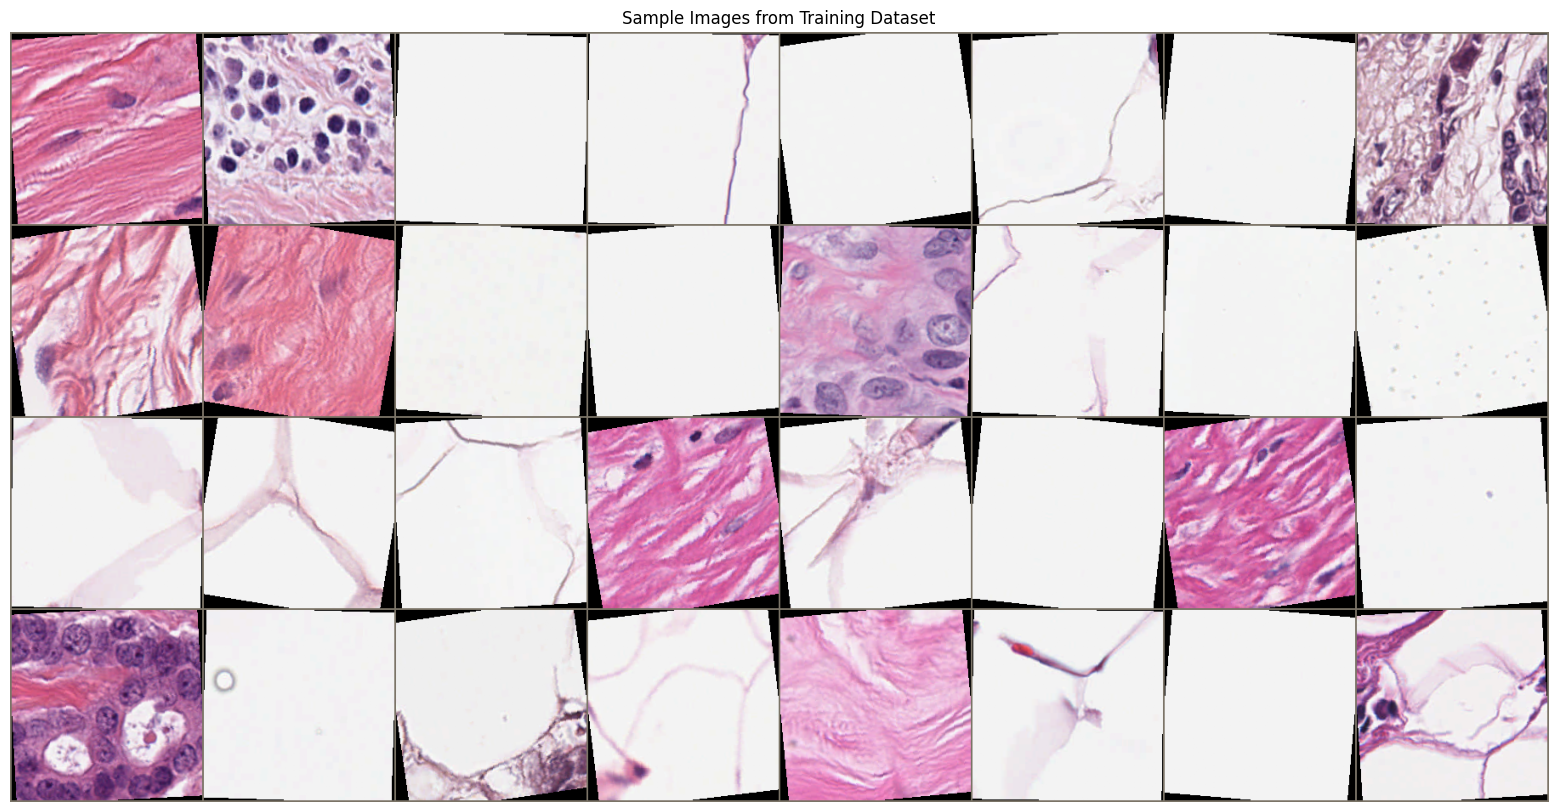

Labels: tensor([5, 2, 1, 0, 1, 0, 1, 5, 5, 5, 1, 1, 6, 0, 1, 1, 0, 0, 0, 5, 0, 1, 5, 1,
        6, 1, 1, 0, 5, 0, 1, 2])


In [8]:
# Function to denormalize images
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    return tensor * std + mean

# Get a batch of training data
inputs, labels = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Plot images
plt.figure(figsize=(20, 10))
plt.imshow(denormalize(out).squeeze(0).permute(1, 2, 0))  # Add squeeze(0) before permute
plt.axis('off')
plt.title('Sample Images from Training Dataset')
plt.show()

# Print labels
print('Labels:', labels)

# Class names or target labels

In this section, we retrieve and display the class names (target labels) from the training dataset. The class names correspond to the subfolder names in the train_directory, which helps identify the different categories of images being used for training and validation.

Additionally, we print the sizes of both the training and validation datasets to provide an overview of the data distribution. This information is crucial for understanding the scale of the dataset and ensuring it meets the requirements for training your model.

In [9]:
# Class names or target labels
class_names = dataset['train'].classes
print("Classes:", class_names)

# Calculate dataset sizes
dataset_sizes = {
    'train': len(dataset['train']),
    'valid': len(dataset['valid'])
}

# Print the train and validation data sizes
print("Training-set size:", dataset_sizes['train'], "\nValidation-set size:", dataset_sizes['valid'])


Classes: ['Adipose', 'Background', 'Immune cells', 'Necrosis', 'Normal', 'Stroma', 'Tumor', 'complex']
Training-set size: 17272 
Validation-set size: 4016


# Set default device as gpu, if available

In this section, we check if a GPU is available for computation and set the device accordingly. Utilizing a GPU can significantly speed up the training and inference processes in deep learning models. If a GPU is not available, we fall back to using the CPU.

This setup is essential to ensure that your code runs efficiently on the available hardware, allowing for faster model training and evaluation.

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Loading a Pretrained Model for Fine-Tuning

In this section, we load the ResNet-50 model pretrained on ImageNet. Using a pretrained model allows us to leverage the learned features from a large dataset, which can significantly improve performance on our specific task, especially when we have limited training data.

**Loading the Model:** We load the ResNet-50 architecture using torchvision.models. Setting pretrained=True initializes the model with weights learned from the ImageNet dataset.

**Modifying the Final Layer:**

If RETURN_PREACTIVATION is set to True, we remove the final fully connected layer to output features directly, which can be useful for certain tasks.
Otherwise, we replace the final layer with a new fully connected layer that has the number of output features equal to the number of classes in our dataset.

**Transferring the Model to GPU:** The model is then moved to the GPU (if available) using the previously set device. This allows us to take advantage of the GPU's computational power during training.

In [11]:
print("\nLoading resnet50 for finetuning ...\n")

model = torchvision.models.__dict__['resnet50'](pretrained=True)
if RETURN_PREACTIVATION:
    model.fc = torch.nn.Sequential()
else:
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

model_ft = model.cuda()

# Transfer the model to GPU
model_ft = model_ft.to(device)


Loading resnet50 for finetuning ...



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 167MB/s]


# Printing the Model Summary

In this section, we print a summary of the model, which includes details about the layers, parameters, and whether each parameter requires gradients for training.

**Enumerating Model Parameters:** We iterate over the named parameters of the model using model.named_parameters(). This provides both the parameter names and their corresponding tensors. The requires_grad attribute indicates whether the parameter will be updated during training (i.e., if gradients will be computed for it).

**Using the summary Function:** The summary function from torchsummary provides a comprehensive overview of the model architecture. It displays information such as the output shape of each layer, the number of parameters, and the total number of trainable parameters in the model. The input_size argument specifies the shape of the input images that the model expects.

In [12]:
# Print model summary
print('Model Summary:-\n')
for num, (name, param) in enumerate(model_ft.named_parameters()):
    print(num, name, param.requires_grad )
summary(model_ft, input_size=(3, 224, 224))
# print(model_ft)

Model Summary:-

0 conv1.weight True
1 bn1.weight True
2 bn1.bias True
3 layer1.0.conv1.weight True
4 layer1.0.bn1.weight True
5 layer1.0.bn1.bias True
6 layer1.0.conv2.weight True
7 layer1.0.bn2.weight True
8 layer1.0.bn2.bias True
9 layer1.0.conv3.weight True
10 layer1.0.bn3.weight True
11 layer1.0.bn3.bias True
12 layer1.0.downsample.0.weight True
13 layer1.0.downsample.1.weight True
14 layer1.0.downsample.1.bias True
15 layer1.1.conv1.weight True
16 layer1.1.bn1.weight True
17 layer1.1.bn1.bias True
18 layer1.1.conv2.weight True
19 layer1.1.bn2.weight True
20 layer1.1.bn2.bias True
21 layer1.1.conv3.weight True
22 layer1.1.bn3.weight True
23 layer1.1.bn3.bias True
24 layer1.2.conv1.weight True
25 layer1.2.bn1.weight True
26 layer1.2.bn1.bias True
27 layer1.2.conv2.weight True
28 layer1.2.bn2.weight True
29 layer1.2.bn2.bias True
30 layer1.2.conv3.weight True
31 layer1.2.bn3.weight True
32 layer1.2.bn3.bias True
33 layer2.0.conv1.weight True
34 layer2.0.bn1.weight True
35 layer2.0.b

# Defining the Loss Function
In this section, we define the loss function used to evaluate the model's performance during training.

**Loss Function:** We use nn.CrossEntropyLoss(), which is commonly used for multi-class classification problems. This loss function combines LogSoftmax and NLLLoss in one single class. It is designed to work with raw, unnormalized scores (logits) from the model, making it suitable for our use case where we have multiple classes to predict.

**Purpose:** The cross-entropy loss measures the difference between the predicted probabilities (after applying softmax) and the actual class labels. During training, the model aims to minimize this loss, leading to improved accuracy on the classification task.

In [13]:
criterion = nn.CrossEntropyLoss()

# Defining the Optimizer
In this section, we define the optimizer that will be used to update the model parameters during training.

**Optimizer Selection:** We use optim.SGD, which stands for Stochastic Gradient Descent. It is a widely-used optimization algorithm that updates the model parameters based on the gradients computed from the loss function.

**Model Parameters:** model_ft.parameters() retrieves all the parameters of the model that need to be optimized.

**Learning Rate (lr):** We set the learning rate to 0.001, which controls how much to change the model parameters in response to the estimated gradients. A smaller learning rate may lead to more stable convergence, while a larger one can speed up training but may risk overshooting the optimal values.

**Momentum:** We set momentum to 0.9, which helps accelerate SGD in the relevant direction and dampens oscillations. Momentum keeps track of the past gradients to smooth out updates, allowing for faster convergence.

In [14]:
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Defining the Learning Rate Scheduler


In this section, we define a learning rate scheduler that adjusts the learning rate during training.

**Scheduler Selection:** We use lr_scheduler.StepLR, which reduces the learning rate by a specified factor after a set number of epochs. This approach can help improve convergence, especially in later stages of training.

**Optimizer:** optimizer_ft is passed to the scheduler, allowing it to adjust the learning rate used by this optimizer.

**Step Size (step_size):** We set step_size=25, which indicates that the learning rate will be decreased every 25 epochs. This helps the model stabilize as it approaches convergence.

**Decay Factor (gamma):** We set gamma=0.1, which specifies that the learning rate will be multiplied by 0.1 after every step. This reduction can lead to more refined updates to the model parameters as training progresses.

In [15]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

# Model Training Routine
In this section, we define a function train_model that orchestrates the training and validation process for the deep learning model.

**Function Definition:**

1. model: The neural network model to be trained.

2. criterion: The loss function used to evaluate the model's performance.

3. optimizer: The optimization algorithm to update the model's parameters.

4. scheduler: The learning rate scheduler to adjust the learning rate during training.

5. num_epochs: The total number of epochs for training.

**Initialization:**

1. The best model weights and the best accuracy are initialized. The model's state is saved to compare later for the best performance.
2. A TensorBoard SummaryWriter is created to log training metrics for visualization.
   
**Training Loop:**

1. A loop iterates through each epoch. For each epoch, the model alternates between training and validation phases.
2. The model is set to training mode (model.train()) for the training phase and evaluation mode (model.eval()) for the validation phase.

**Data Iteration:**

1. Within each phase, the code iterates through the data using the dataloaders.

2. Inputs and labels are moved to the appropriate device (CPU or GPU) for processing.

3. The optimizer gradients are zeroed to prevent accumulation from previous iterations.

**Forward Pass:**

1. The model performs a forward pass to generate predictions.

2. The loss is computed using the specified criterion.

3. If in training mode, backpropagation is performed using loss.backward() to compute gradients, and optimizer.step() updates the model parameters.


**Loss and Accuracy Calculation:**

1. The running loss and the number of correct predictions are accumulated to calculate the epoch loss and accuracy for both training and validation phases.
Logging Metrics:

2. Training and validation loss and accuracy are logged using TensorBoard. This provides a visual representation of the training progress.

**Best Model Checkpointing:**

1. If the validation accuracy of the current epoch exceeds the best accuracy recorded, the model weights are saved for later use.

**Completion and Return:**

1. After all epochs are completed, the function prints the total training time and the best validation accuracy achieved.
2. The model loads the best weights and is returned for further use.

In [ ]:
import time
import copy
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

# Model training routine
print("\nTraining:-\n")
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Lists to store loss and accuracy values
    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []

    # Tensorboard summary
    writer = SummaryWriter()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Record training loss and accuracy for each phase
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item())
                writer.add_scalar('Train/Loss', epoch_loss, epoch)
                writer.add_scalar('Train/Accuracy', epoch_acc, epoch)
            else:
                valid_losses.append(epoch_loss)
                valid_accs.append(epoch_acc.item())
                writer.add_scalar('Valid/Loss', epoch_loss, epoch)
                writer.add_scalar('Valid/Accuracy', epoch_acc, epoch)

            # Deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Plotting the training and validation loss and accuracy
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), valid_losses, label='Valid Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(range(num_epochs), train_accs, label='Train Accuracy')
    plt.plot(range(num_epochs), valid_accs, label='Valid Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.show()

    return model



Training:-



# Train the model

Epoch 0/2
----------
train Loss: 0.3992 Acc: 0.8770
valid Loss: 0.2958 Acc: 0.9128

Epoch 1/2
----------
train Loss: 0.2075 Acc: 0.9342
valid Loss: 0.4963 Acc: 0.8454

Epoch 2/2
----------
train Loss: 0.1559 Acc: 0.9495
valid Loss: 0.4386 Acc: 0.8817

Training complete in 17m 36s
Best val Acc: 0.912849


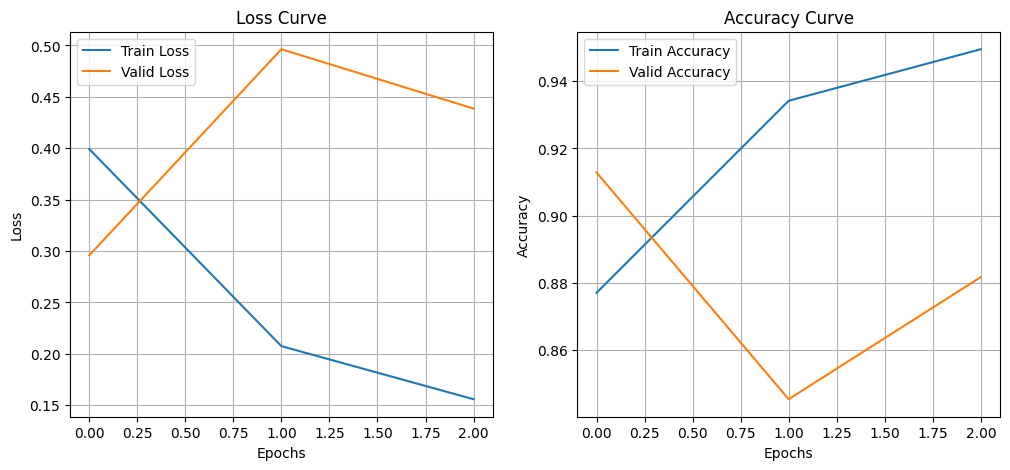


Saving the model...


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)
# Save the entire model
print("\nSaving the model...")
torch.save(model_ft, model_save_path)

# Paths for evaluation image directory and model checkpoint

In [16]:
EVAL_DIR = destination_directory + '/test'
EVAL_MODEL= model_save_path
print(EVAL_DIR)

/content/drive/MyDrive/Optima/data/data/split/test


# Load the model for evaluation

In [17]:
model = torch.load(EVAL_MODEL)

<ipython-input-17-450444b1b201>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(EVAL_MODEL)


# Configure batch size and number of CPUs

In [18]:
# num_cpu = multiprocessing.cpu_count()
bs = 32

# Prepare the eval data loader

In [19]:
import torch
from torch.utils.data import DataLoader  # Use this directly, no need for `data.DataLoader`
from torchvision import datasets, transforms

# Define the evaluation directory path
# EVAL_DIR = EVAL_DIR

# Define the evaluation transform
eval_transform = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the evaluation dataset
eval_dataset = datasets.ImageFolder(root=EVAL_DIR, transform=eval_transform)

# Replace `data.DataLoader` with `DataLoader`
eval_loader = DataLoader(eval_dataset, batch_size=bs, shuffle=True, num_workers=0, pin_memory=True)


# Enable GPU mode, if CUDA is available

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Number of classes and dataset size

In [21]:
num_classes = len(eval_dataset.classes)
dsize = len(eval_dataset)

In [22]:
dsize

5401

# Class label names

In [23]:
class_names = ['Adipose', 'Background', 'Immune cells', 'Necrosis', 'Normal', 'Stroma', 'Tumor', 'complex']

# Initialize the prediction and label lists

In [24]:
predlist = torch.zeros(0, dtype=torch.long, device='cpu')
lbllist = torch.zeros(0, dtype=torch.long, device='cpu')

# Initilizations

In [25]:
correct = 0
total = 0
predlist = torch.tensor([])  # to store the predicted labels
lbllist = torch.tensor([])   # to store the true labels
all_probs = torch.tensor([])  # to store probabilities for ROC curve

# Model Evaluation Mode:

In [26]:
model.eval()  # Ensure the model is in evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Evaluate the model accuracy on the test dataset

In [27]:
with torch.no_grad():
    for images, labels in eval_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        # Get probabilities using softmax
        probs = torch.softmax(outputs, dim=1)
        all_probs = torch.cat([all_probs, probs.cpu()])

        # Get the predicted class with the highest score
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predlist = torch.cat([predlist, predicted.view(-1).cpu()])
        lbllist = torch.cat([lbllist, labels.view(-1).cpu()])

# Convert lbllist and predlist to integers for bincount
lbllist = lbllist.to(torch.int64)
predlist = predlist.to(torch.int64)

# Overall accuracy
overall_accuracy = 100 * correct / total
print('Accuracy of the network on the {:d} test images: {:.2f}%'.format(total, overall_accuracy))

Accuracy of the network on the 5401 test images: 86.32%


# Plotting

Confusion Matrix
----------------
[[1369   51    2    0    3   32   13    2]
 [  17 1482    0    0    0    0    0    1]
 [  10    0  365    0    1    1   29    0]
 [   0    0    8    0    0    0    7    0]
 [  22    1   39    2   22   52   73   26]
 [  36    1    0    0    9 1017   35    9]
 [   3    0   15    0    1   26  448    0]
 [   8    0    0    0    0   78    0   79]] 



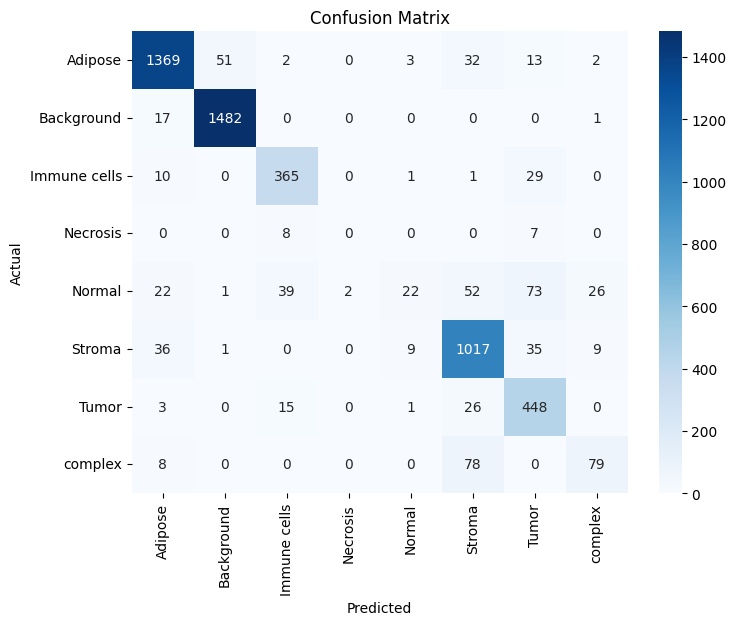

Shape of lbllist_one_hot: (5395, 8)
Shape of all_probs: torch.Size([5395, 8])
Class Adipose: AUC = 0.98
Class Background: AUC = 1.00
Class Immune cells: AUC = 0.97
Class Necrosis: AUC = 0.65
Class Normal: AUC = 0.93
Class Stroma: AUC = 0.97
Class Tumor: AUC = 0.97
Class complex: AUC = 0.84


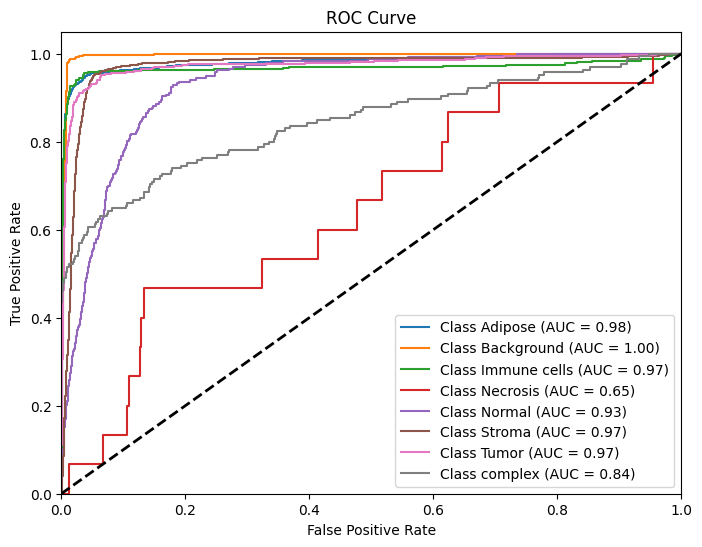

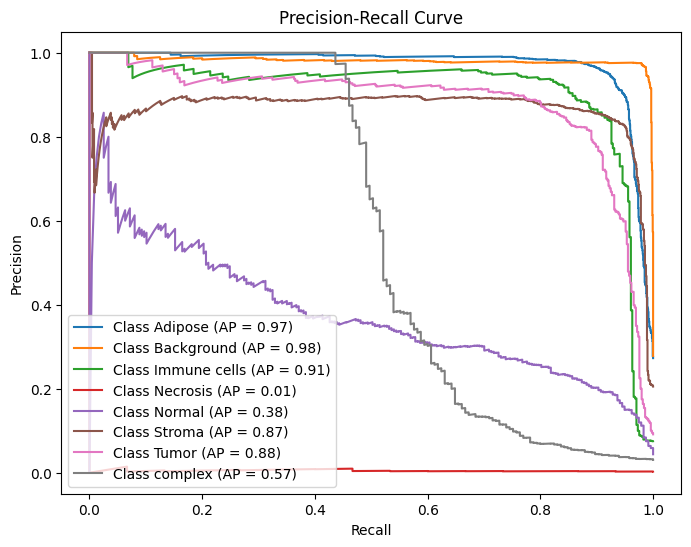

In [ ]:
# Confusion Matrix
n_classes = len(eval_dataset.classes)
conf_mat = confusion_matrix(lbllist.numpy(), predlist.numpy(), labels=np.arange(n_classes))  # Ensure all classes are included
print('Confusion Matrix')
print('-'*16)
print(conf_mat,'\n')

# Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=eval_dataset.classes,
            yticklabels=eval_dataset.classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve and AUC
lbllist_one_hot = np.eye(n_classes)[lbllist.numpy()]  # One-hot encode the labels
fpr = {}
tpr = {}
roc_auc = {}

# Check the shapes of lbllist_one_hot and all_probs
print("Shape of lbllist_one_hot:", lbllist_one_hot.shape)
print("Shape of all_probs:", all_probs.shape)

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(lbllist_one_hot[:, i], all_probs[:, i].numpy())
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f"Class {eval_dataset.classes[i]}: AUC = {roc_auc[i]:.2f}")

# Plot ROC Curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {eval_dataset.classes[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for random guess
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve and Average Precision
precision = {}
recall = {}
avg_precision = {}

# Compute Precision-Recall curve and Average Precision for each class
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(lbllist_one_hot[:, i], all_probs[:, i].numpy())
    avg_precision[i] = average_precision_score(lbllist_one_hot[:, i], all_probs[:, i].numpy())

# Plot Precision-Recall Curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f"Class {eval_dataset.classes[i]} (AP = {avg_precision[i]:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()


# Hook to extract gradients and feature maps

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


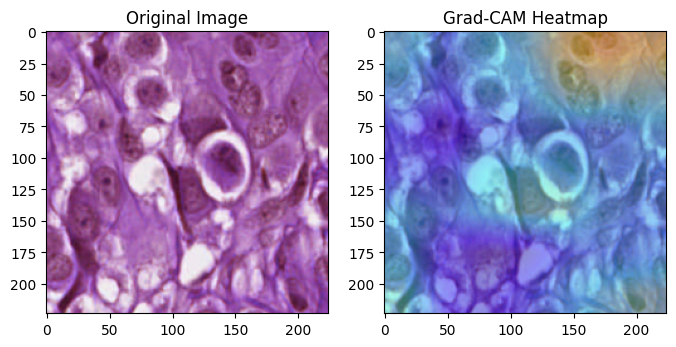

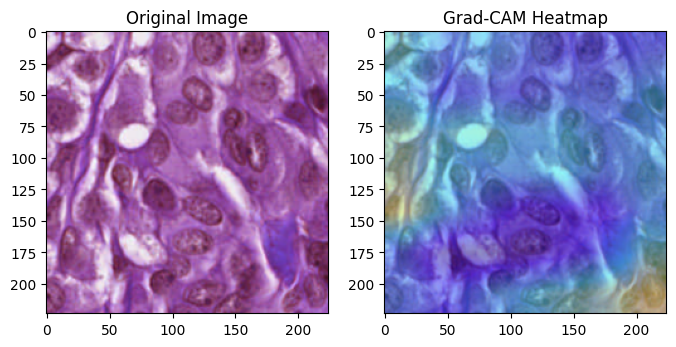

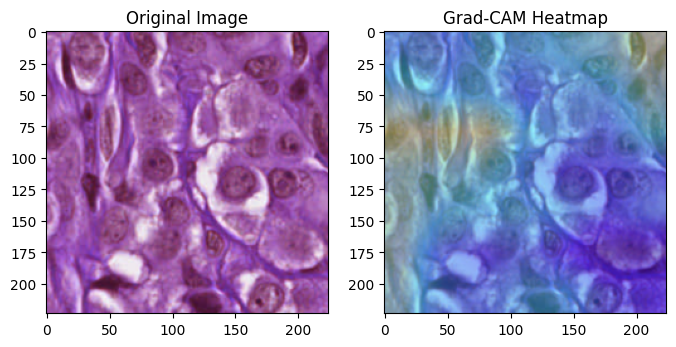

In [ ]:
# SaveFeatures class for capturing feature maps and gradients
class SaveFeatures:
    def __init__(self, module):
        self.module = module
        self.features = None
        self.gradients = None
        self.hook = module.register_forward_hook(self.hook_fn)
        self.hook_grad = module.register_backward_hook(self.hook_grad_fn)

    def hook_fn(self, module, input, output):
        self.features = output

    def hook_grad_fn(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]  # Gradient with respect to the output

    def close(self):
        self.hook.remove()
        self.hook_grad.remove()

# GradCam class for generating heatmaps
class GradCam:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.model.eval()

    def __call__(self, x, class_idx=None):
        conv_output = SaveFeatures(self.target_layer)  # Hook to get feature maps and gradients
        model_output = self.model(x)

        if class_idx is None:
            class_idx = torch.argmax(model_output)  # Default to the class with the highest score

        one_hot = torch.zeros((1, model_output.size()[-1]), dtype=torch.float32).to(x.device)
        one_hot[0][class_idx] = 1

        self.model.zero_grad()
        model_output.backward(gradient=one_hot, retain_graph=True)  # Backpropagate for the target class

        # Get the gradients and feature maps from the hook
        gradients = conv_output.gradients
        feature_maps = conv_output.features[0]

        # Perform global average pooling to get the weights
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

        # Multiply feature maps by the pooled gradients
        for i in range(len(pooled_gradients)):
            feature_maps[i, :, :] *= pooled_gradients[i]

        # Average along the channel dimension to get the Grad-CAM heatmap
        heatmap = torch.mean(feature_maps, dim=0).cpu().detach().numpy()

        # Apply ReLU
        heatmap = np.maximum(heatmap, 0)

        # Normalize the heatmap
        heatmap /= np.max(heatmap)
        return heatmap

# Function to overlay Grad-CAM heatmap on the image
def overlay_heatmap(heatmap, img):
    # Resize heatmap to match image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert heatmap to uint8 format
    heatmap = np.uint8(255 * heatmap)

    # Apply color map (e.g., JET) to the heatmap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Convert the original image to uint8 (if it's float32)
    if img.dtype != np.uint8:
        img = np.uint8(255 * img)

    # Ensure the original image has 3 channels (if it's grayscale, convert to RGB)
    if len(img.shape) == 2 or img.shape[2] == 1:  # If grayscale
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # Overlay the heatmap onto the original image
    overlayed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    return overlayed_img

# Load your test image and preprocess
def preprocess_image(image_path, transform):
    image = cv2.imread(image_path, 1)
    image = np.float32(cv2.resize(image, (224, 224))) / 255
    img_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return img_tensor, image

# Function to process a limited number of images in a folder
def process_images_in_folder(folder_path, transform, model, target_layer, limit=10):
    grad_cam = GradCam(model, target_layer)

    # Create a results folder if it doesn't exist
    results_folder = os.path.join(folder_path, 'gradcam_results')
    os.makedirs(results_folder, exist_ok=True)

    # Counter to keep track of the number of processed images
    processed_count = 0

    # Iterate through all images in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.tif') or filename.endswith('.jpg'):  # Add other formats if necessary
            image_path = os.path.join(folder_path, filename)
            image_tensor, original_img = preprocess_image(image_path, transform)

            # Run Grad-CAM
            heatmap = grad_cam(image_tensor.to(device))
            overlayed_image = overlay_heatmap(heatmap, original_img)

            # Save the overlayed image
            result_path = os.path.join(results_folder, f'gradcam_{filename}')
            cv2.imwrite(result_path, overlayed_image)

            # Optional: Display the result
            plt.figure(figsize=(8, 8))
            plt.subplot(1, 2, 1)
            plt.imshow(original_img)
            plt.title('Original Image')

            plt.subplot(1, 2, 2)
            plt.imshow(overlayed_image)
            plt.title('Grad-CAM Heatmap')
            plt.show()

            # Increment the counter
            processed_count += 1
            if processed_count >= limit:  # Stop after processing the specified number of images
                break

# Example usage of Grad-CAM on a limited number of images in a folder
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

# Replace with the layer you want to visualize (e.g., last conv layer in ResNet)
target_layer = model.layer4[-1]  # Last convolutional layer in ResNet

# Specify the folder containing the test images
folder_path = EVAL_DIR + '/Tumor'  # Adjust as necessary

# Process a limited number of images (e.g., 10 images)
process_images_in_folder(folder_path, transform, model, target_layer, limit=3)


# Function to extract features from a target layer

In [ ]:
def extract_features(model, data_loader, target_layer):
    model.eval()  # Set the model to evaluation mode

    all_features = []
    all_labels = []

    # Hook to get the feature maps from the specified layer
    class SaveFeatures:
        def __init__(self, module):
            self.hook = module.register_forward_hook(self.hook_fn)
            self.features = None

        def hook_fn(self, module, input, output):
            self.features = output

        def close(self):
            self.hook.remove()

    # Attach hook to the target layer
    conv_output = SaveFeatures(target_layer)

    # Loop through the dataset
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            output = model(images)
            features = conv_output.features.cpu().detach().numpy()
            all_features.append(features)
            all_labels.append(labels.cpu().numpy())

    conv_output.close()

    # Stack all features and labels together
    all_features = np.vstack(all_features)
    all_labels = np.hstack(all_labels)

    return all_features, all_labels

# Function to generate t-SNE plot
def generate_tsne_plot(features, labels):
    # Flatten the feature maps if needed (depending on the layer you extract from)
    features = features.reshape(features.shape[0], -1)

    # Apply t-SNE to reduce dimensionality to 2D
    tsne = TSNE(n_components=2, random_state=42)
    features_tsne = tsne.fit_transform(features)

    # Create a scatter plot
    plt.figure(figsize=(10, 8))

    # Define colors and labels
    colors = ['magenta', 'red', 'green', 'blue', 'black', 'pink', 'purple', 'cyan']
    class_labels = ['Adipose', 'Background', 'Immune cells', 'Necrosis', 'Normal', 'Stroma', 'Tumor', 'complex']

    # Plot each class separately for visualization
    for class_idx in range(8):
        indices = np.where(labels == class_idx)
        plt.scatter(features_tsne[indices, 0], features_tsne[indices, 1],
                    c=colors[class_idx], label=class_labels[class_idx])

    plt.title('t-SNE plot of Feature Maps')
    plt.legend()
    plt.show()

# Example usage:
# Assume your dataloader is prepared and your model is loaded
# target_layer = model.layer4[-1]  # Example for ResNet last conv layer
all_features, all_labels = extract_features(model, eval_loader, target_layer)

# Generate and plot the t-SNE result

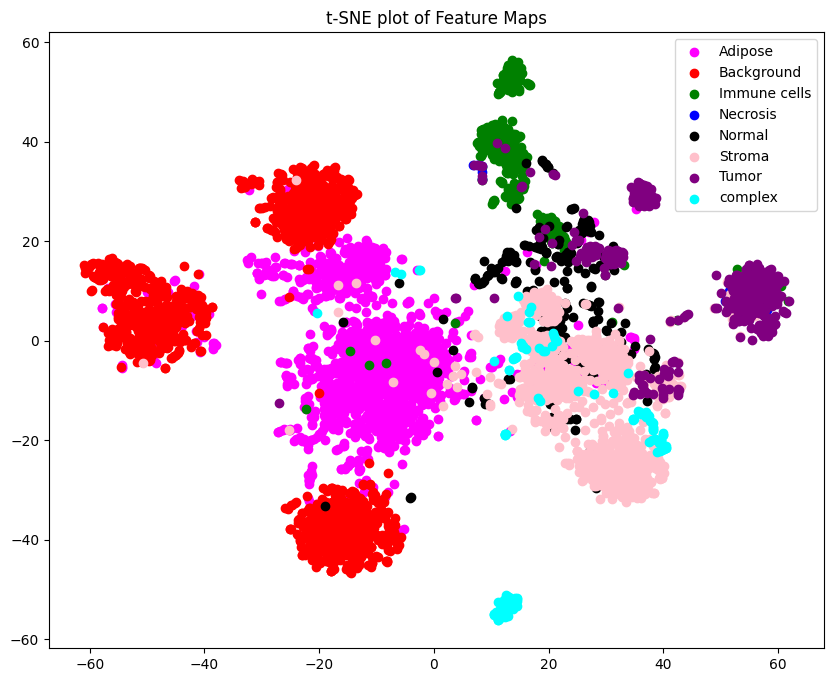

In [ ]:
generate_tsne_plot(all_features, all_labels)

# **Test on TCGA BRCA DX cases**

<ipython-input-28-076019ec5580>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/drive/MyDrive/Optima/checkpoint/model.pth')


Processing folder: TCGA-BH-A0H9-01Z-00-DX1


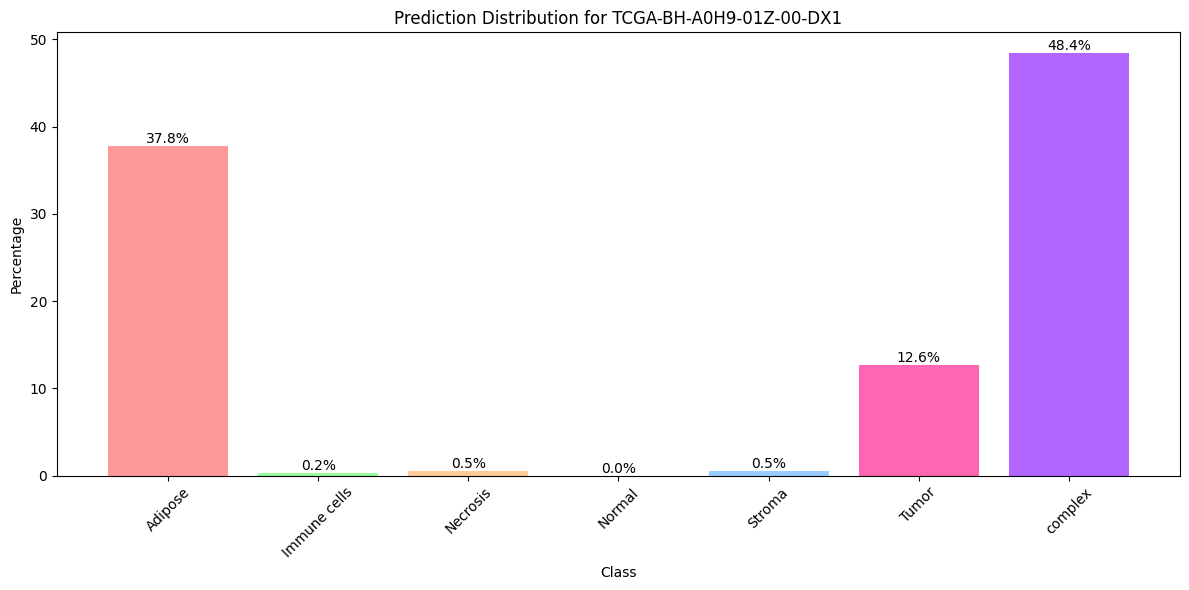

Distribution plot saved for TCGA-BH-A0H9-01Z-00-DX1
Processing folder: TCGA-E2-A1B6-01Z-00-DX1


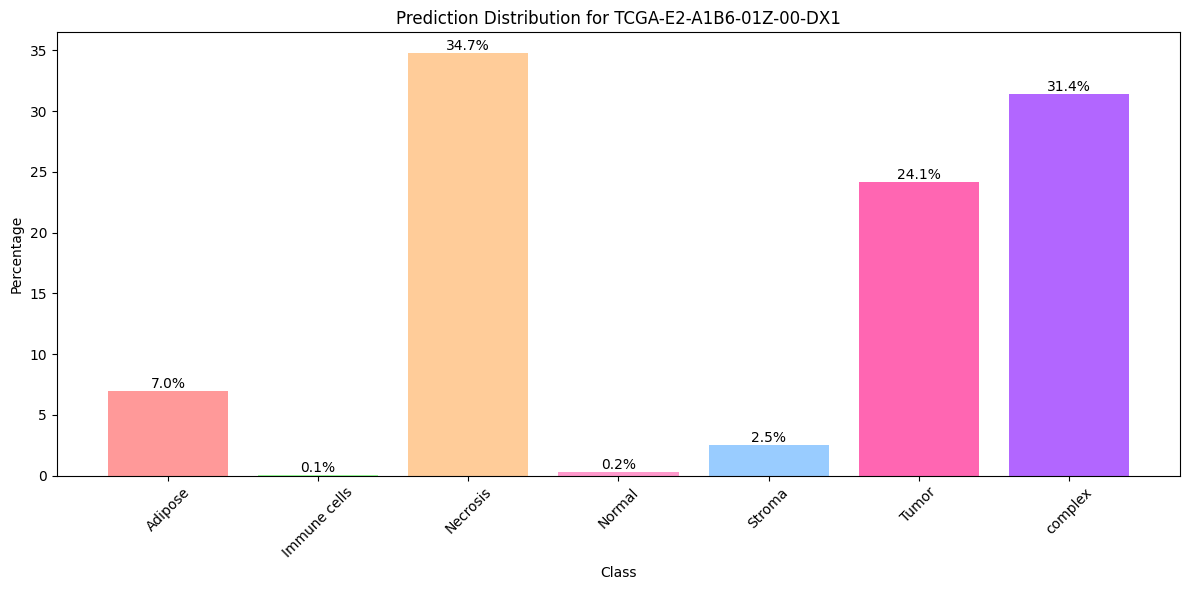

Distribution plot saved for TCGA-E2-A1B6-01Z-00-DX1
Processing folder: TCGA-E2-A15I-01Z-00-DX1


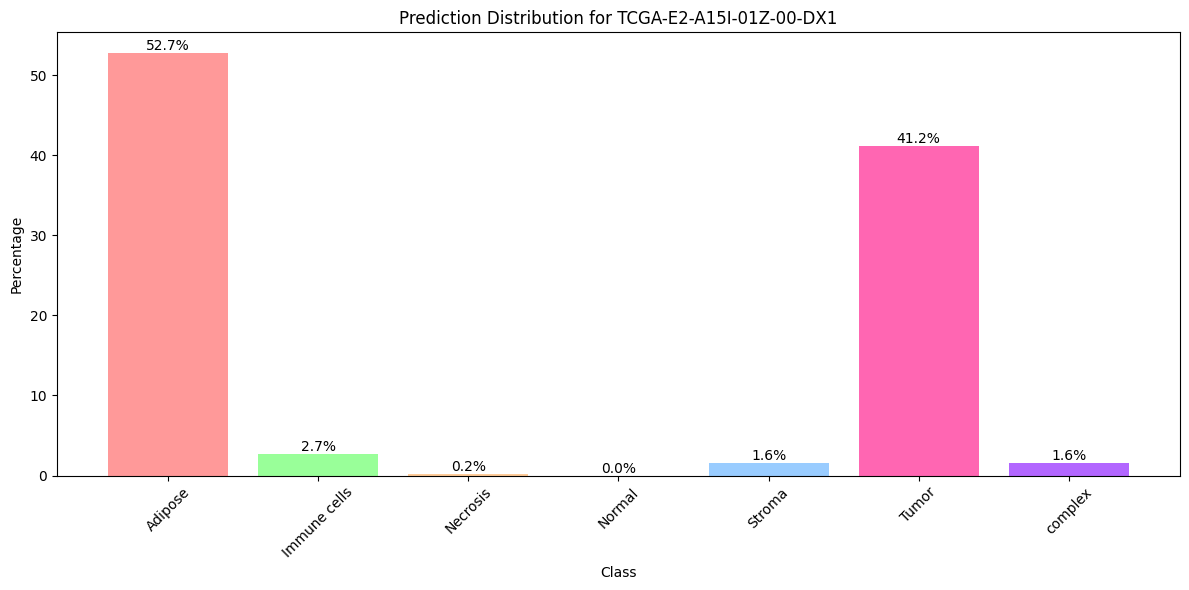

Distribution plot saved for TCGA-E2-A15I-01Z-00-DX1
Processing folder: TCGA-GI-A2C8-01Z-00-DX1


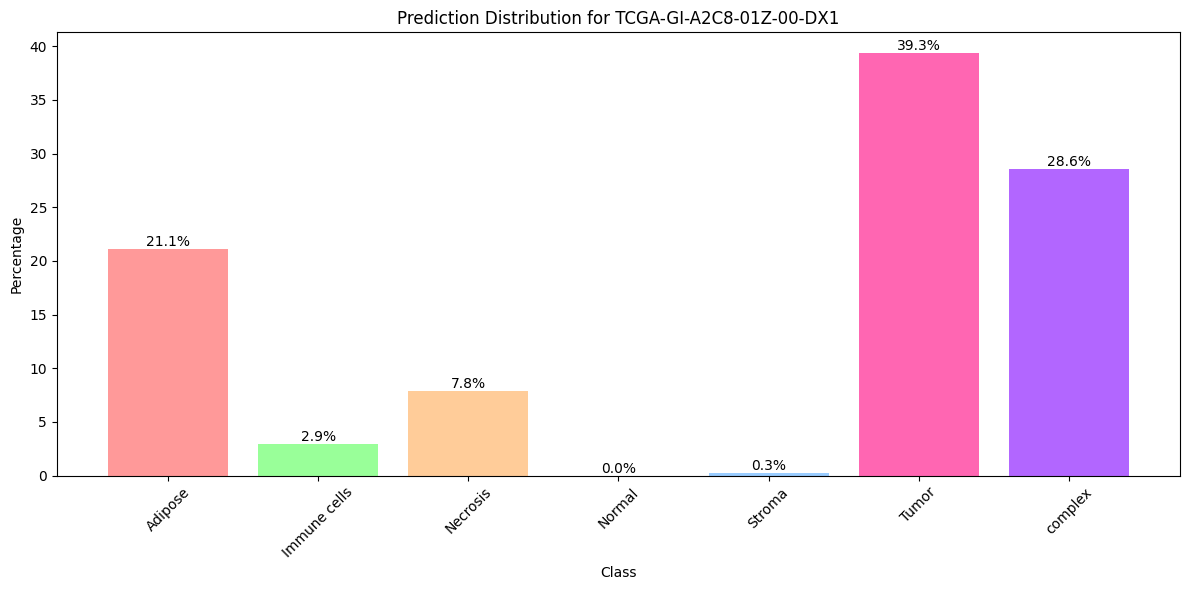

Distribution plot saved for TCGA-GI-A2C8-01Z-00-DX1
Processing folder: TCGA-A2-A0ST-01Z-00-DX1


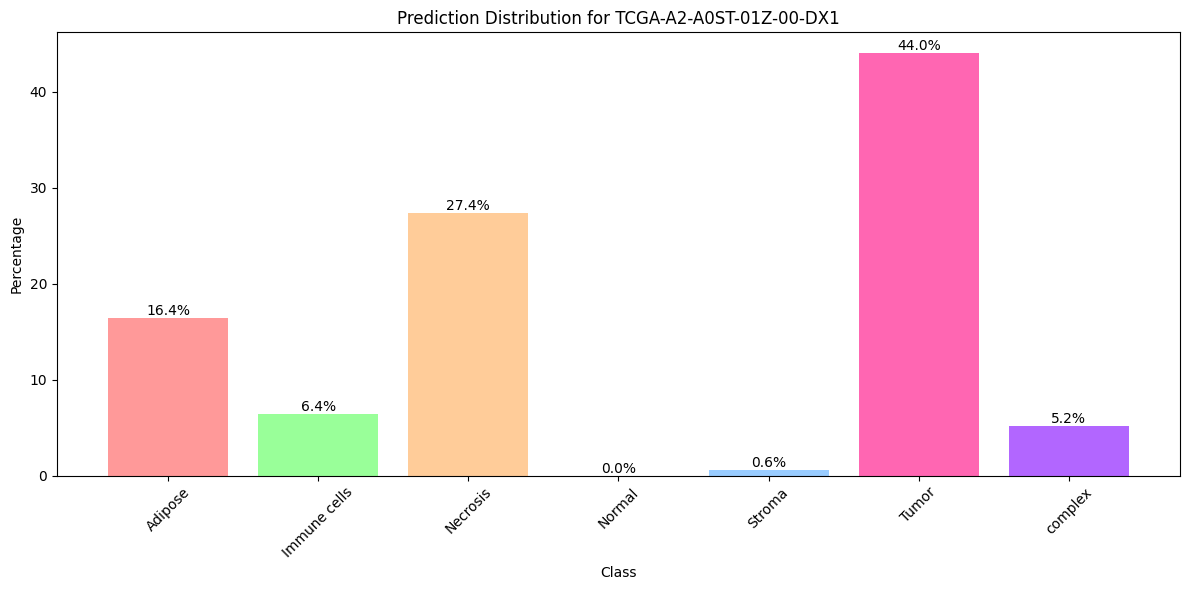

Distribution plot saved for TCGA-A2-A0ST-01Z-00-DX1
Processing folder: TCGA-A2-A25F-01Z-00-DX1


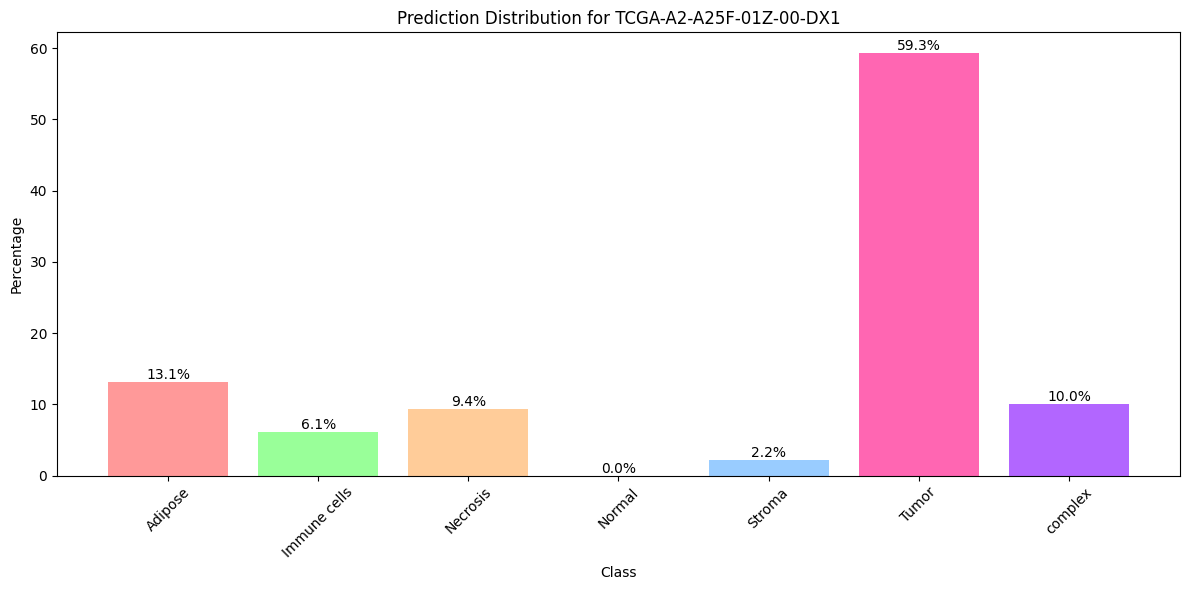

Distribution plot saved for TCGA-A2-A25F-01Z-00-DX1
Processing folder: TCGA-A7-A13G-01Z-00-DX1


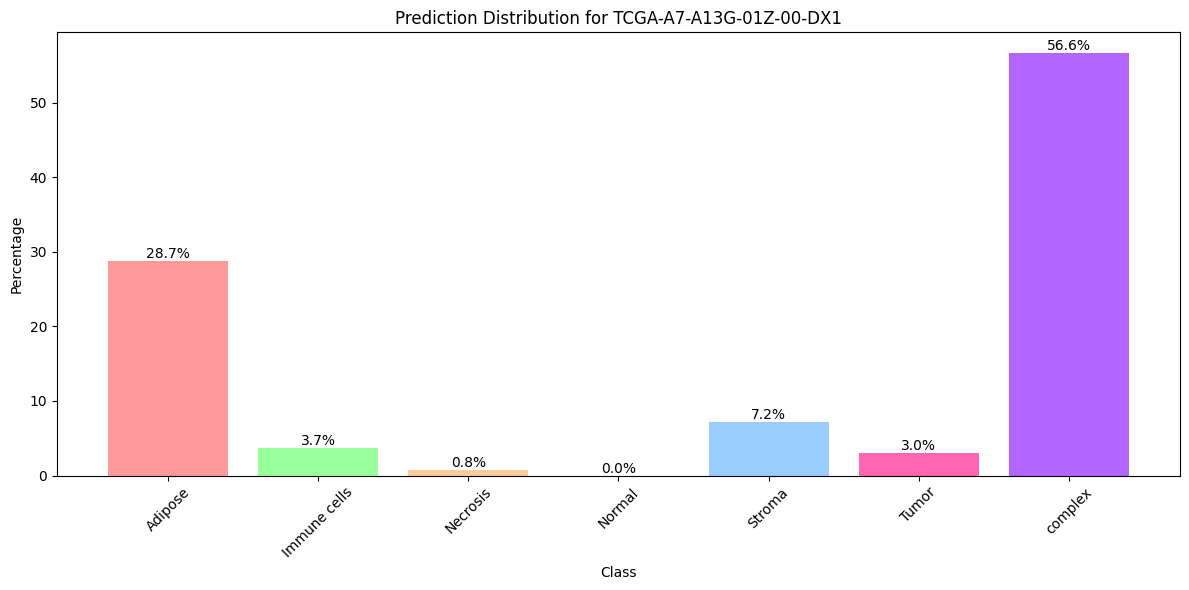

Distribution plot saved for TCGA-A7-A13G-01Z-00-DX1
Processing folder: TCGA-B6-A0RT-01Z-00-DX1


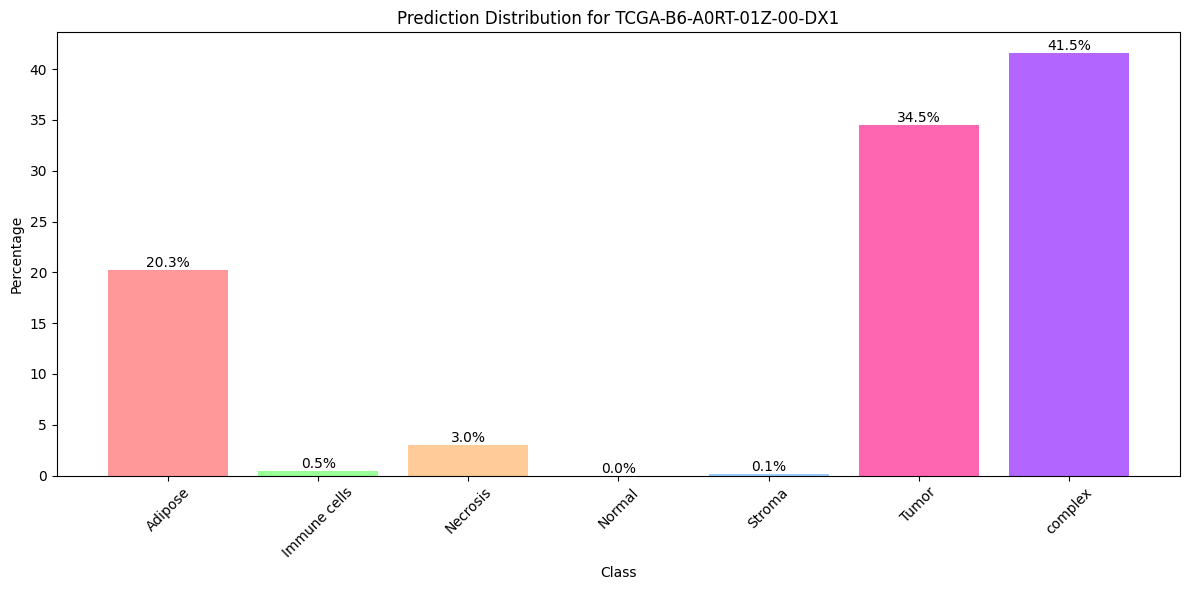

Distribution plot saved for TCGA-B6-A0RT-01Z-00-DX1
Processing folder: TCGA-B6-A3ZX-01A-01-TS1


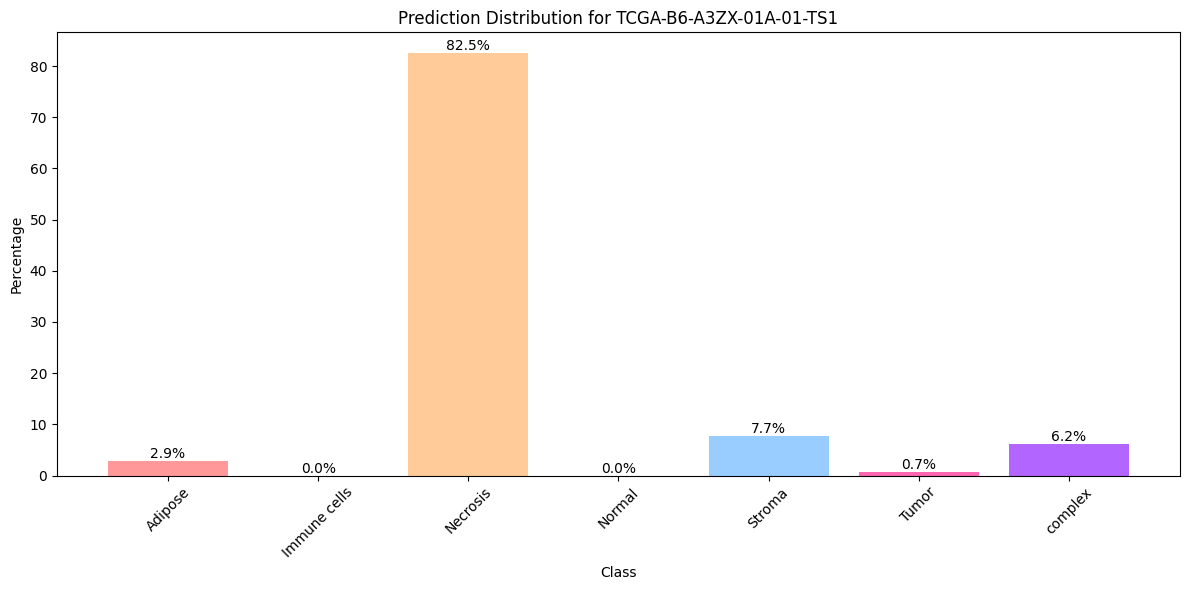

Distribution plot saved for TCGA-B6-A3ZX-01A-01-TS1
Processing folder: TCGA-BH-A0B5-01Z-00-DX1


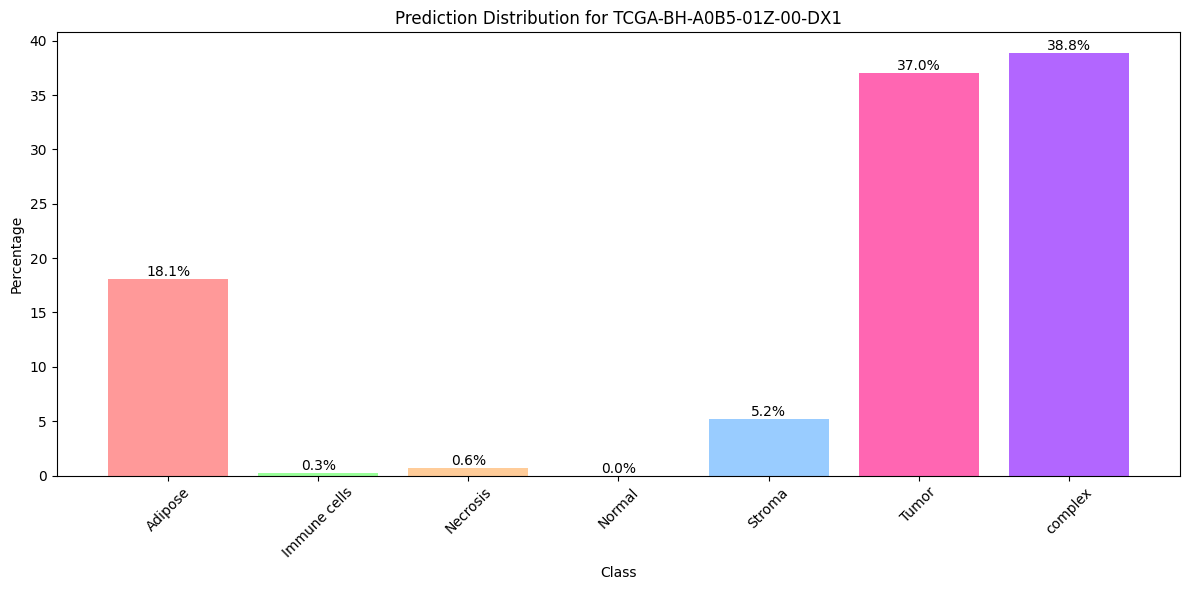

Distribution plot saved for TCGA-BH-A0B5-01Z-00-DX1
All folders processed and distribution plots saved.


In [28]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transformation for the input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load your trained model
model = torch.load('/content/drive/MyDrive/Optima/checkpoint/model.pth')
model.eval()
model.to(device)

# Define the class names and corresponding colors
class_names = ['Adipose', 'Immune cells', 'Necrosis', 'Normal', 'Stroma', 'Tumor', 'complex']
class_colors = ['#FF9999', '#99FF99', '#FFCC99', '#FF99CC', '#99CCFF', '#FF66B2', '#B266FF']

# Custom dataset class
class ImageFolderDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

def predict_folder(folder_path):
    predictions = []
    dataset = ImageFolderDataset(folder_path, transform=transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

    with torch.no_grad():
        for inputs in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())

    return predictions

def plot_distribution(predictions, folder_name):
    # Filter out predictions for 'Background' class
    background_index = 7  # Update this based on your class indices
    valid_predictions = [p for p in predictions if p != background_index]

    # Calculate percentages
    class_counts = np.bincount(valid_predictions, minlength=len(class_names))
    total_count = sum(class_counts)
    percentages = (class_counts / total_count) * 100

    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(class_names)), percentages, color=class_colors)
    plt.title(f'Prediction Distribution for {folder_name}')
    plt.xlabel('Class')
    plt.ylabel('Percentage')
    plt.xticks(range(len(class_names)), class_names, rotation=45)

    # Add percentage labels on top of each bar
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{percentages[i]:.1f}%',
                 ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(f'{folder_name}_distribution.png')
    plt.show()  # This will display the plot
    plt.close()

# Main execution
root_folder = '/content/drive/MyDrive/Optima/Patches/Patches2'
for folder_name in os.listdir(root_folder):
    folder_path = os.path.join(root_folder, folder_name)
    if os.path.isdir(folder_path):
        print(f"Processing folder: {folder_name}")
        predictions = predict_folder(folder_path)
        plot_distribution(predictions, folder_name)
        print(f"Distribution plot saved for {folder_name}")

print("All folders processed and distribution plots saved.")


Displaying samples for folder: TCGA-BH-A0H9-01Z-00-DX1


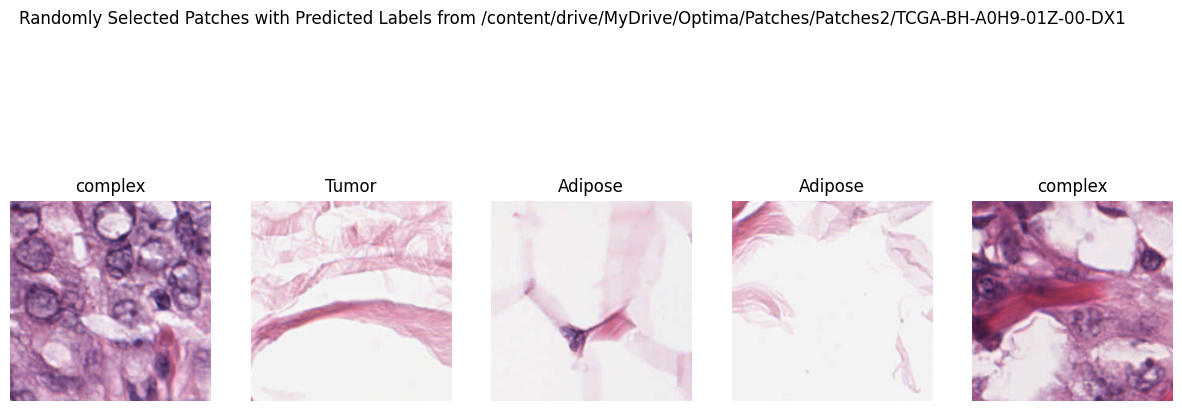

Displayed patches for TCGA-BH-A0H9-01Z-00-DX1
Displaying samples for folder: TCGA-E2-A1B6-01Z-00-DX1


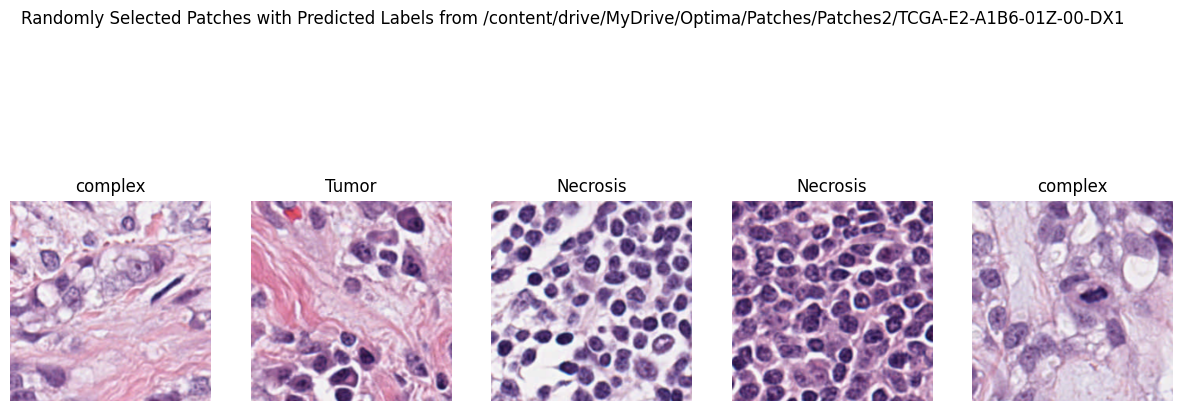

Displayed patches for TCGA-E2-A1B6-01Z-00-DX1
Displaying samples for folder: TCGA-E2-A15I-01Z-00-DX1


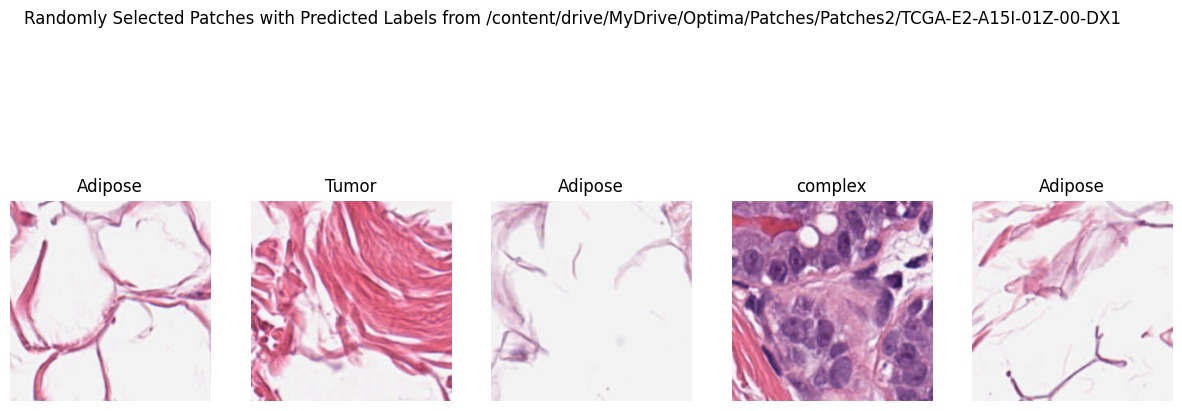

Displayed patches for TCGA-E2-A15I-01Z-00-DX1
Displaying samples for folder: TCGA-GI-A2C8-01Z-00-DX1


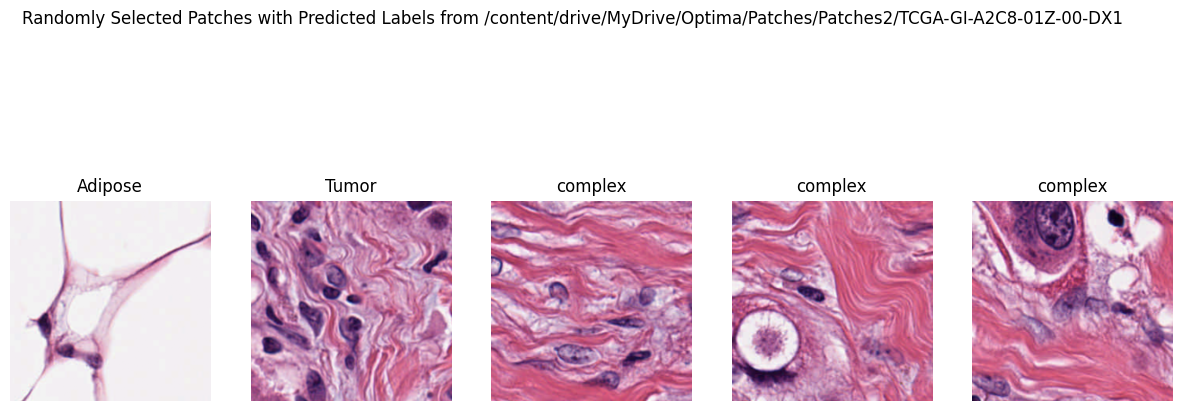

Displayed patches for TCGA-GI-A2C8-01Z-00-DX1
Displaying samples for folder: TCGA-A2-A0ST-01Z-00-DX1


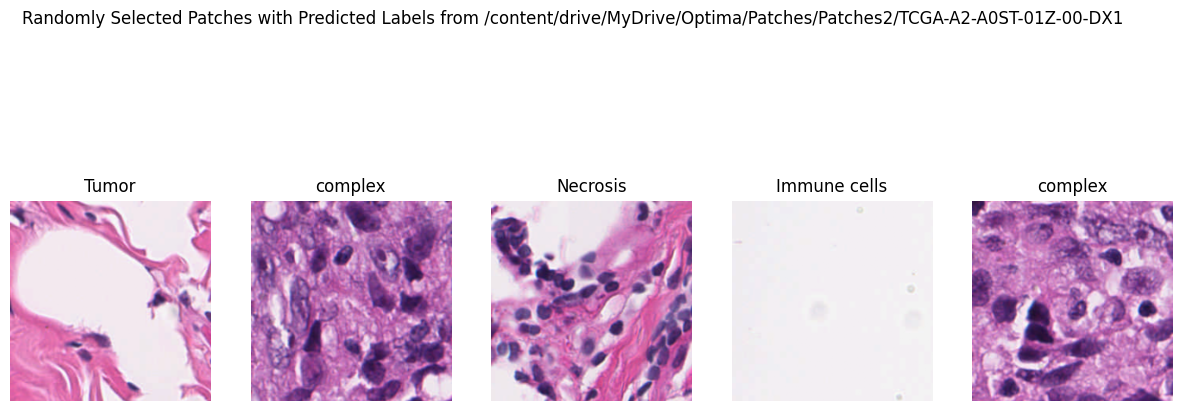

Displayed patches for TCGA-A2-A0ST-01Z-00-DX1
Displaying samples for folder: TCGA-A2-A25F-01Z-00-DX1


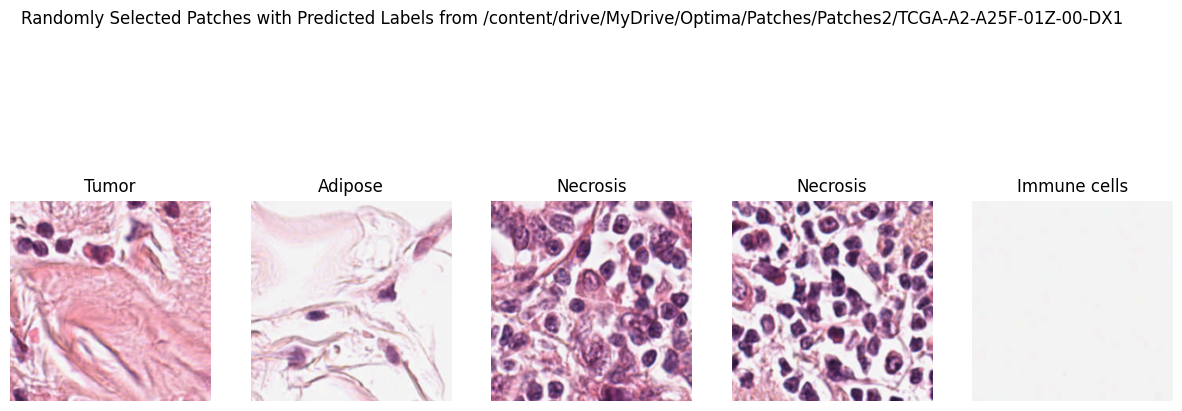

Displayed patches for TCGA-A2-A25F-01Z-00-DX1
Displaying samples for folder: TCGA-A7-A13G-01Z-00-DX1


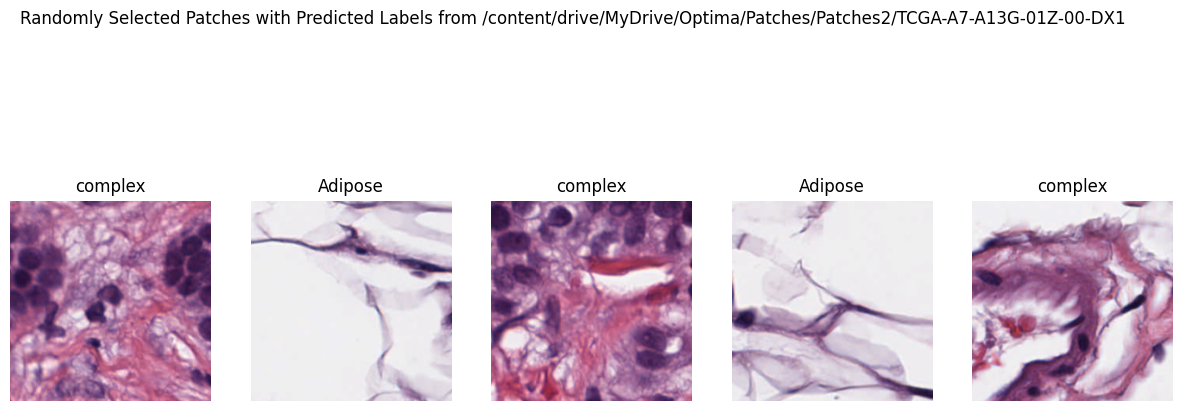

Displayed patches for TCGA-A7-A13G-01Z-00-DX1
Displaying samples for folder: TCGA-B6-A0RT-01Z-00-DX1


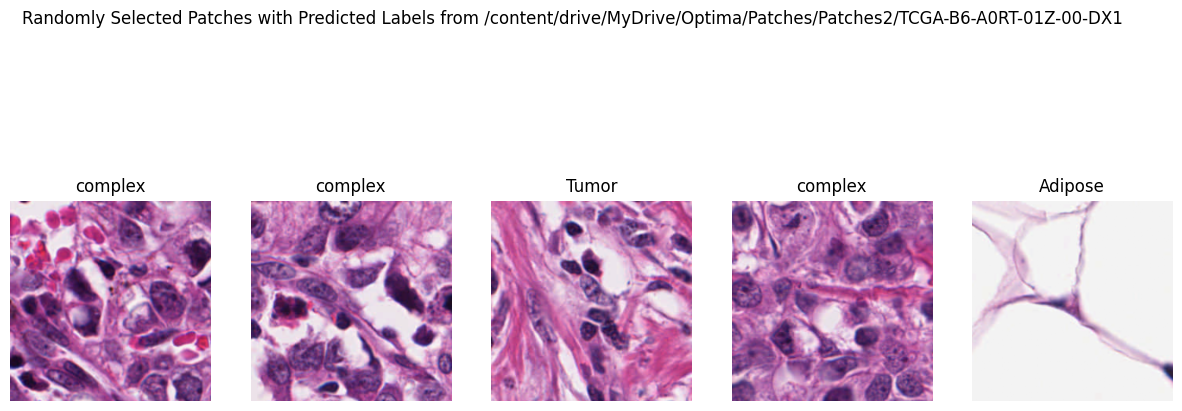

Displayed patches for TCGA-B6-A0RT-01Z-00-DX1
Displaying samples for folder: TCGA-B6-A3ZX-01A-01-TS1


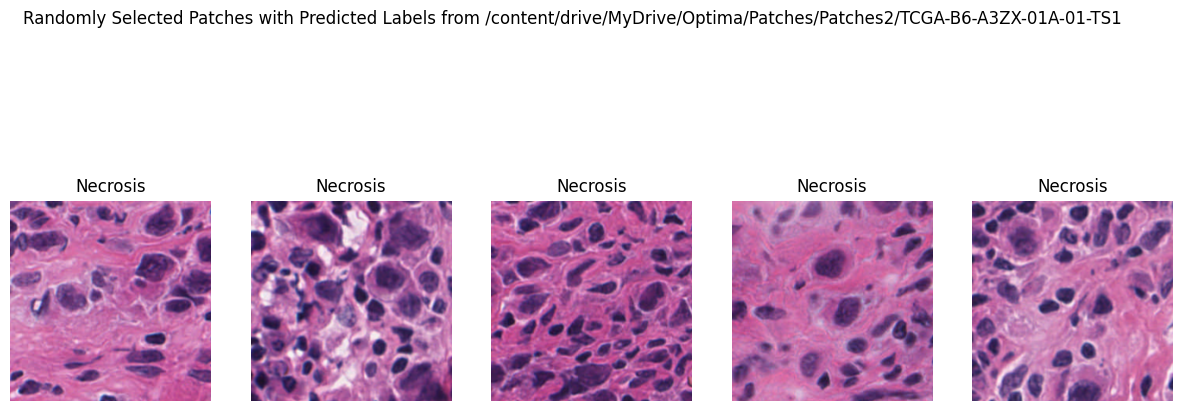

Displayed patches for TCGA-B6-A3ZX-01A-01-TS1
Displaying samples for folder: TCGA-BH-A0B5-01Z-00-DX1


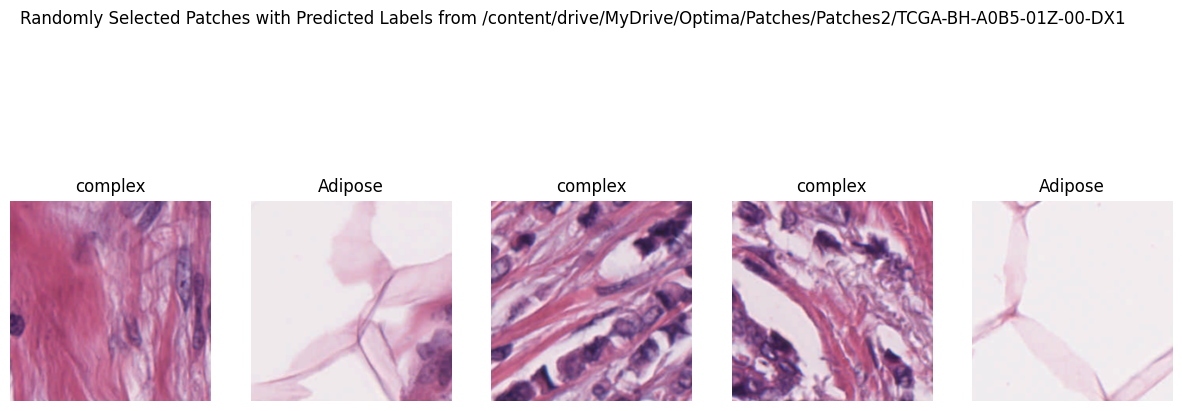

Displayed patches for TCGA-BH-A0B5-01Z-00-DX1


In [29]:
import random
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def display_patches_with_labels(folder_path, num_samples=5):
    """
    Display randomly selected patches from a folder along with their predicted class labels.

    Parameters:
    - folder_path: Path to the folder containing image patches.
    - num_samples: Number of patches to display from each folder.
    """
    dataset = ImageFolderDataset(folder_path, transform=transform)
    dataloader = DataLoader(dataset, batch_size=num_samples, shuffle=True)

    # Get a batch of images from the folder
    images = next(iter(dataloader))
    images = images.to(device)

    # Run predictions on the batch
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    # Move images and predictions back to CPU for display
    images = images.cpu()
    preds = preds.cpu()

    # Plot the images with their predicted labels
    plt.figure(figsize=(15, 6))
    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i+1)
        img = images[i].permute(1, 2, 0)  # Convert to HWC format for display
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Unnormalize
        img = img.numpy().clip(0, 1)  # Ensure pixel values are in [0, 1]

        plt.imshow(img)
        plt.title(class_names[preds[i]])
        plt.axis('off')

    plt.suptitle(f'Randomly Selected Patches with Predicted Labels from {folder_path}')
    plt.show()

# Main execution
root_folder = '/content/drive/MyDrive/Optima/Patches/Patches2'
for folder_name in os.listdir(root_folder):
    folder_path = os.path.join(root_folder, folder_name)
    if os.path.isdir(folder_path):
        print(f"Displaying samples for folder: {folder_name}")
        display_patches_with_labels(folder_path, num_samples=5)
        print(f"Displayed patches for {folder_name}")


# End